In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from architecture.deep_binary_classifier import DeepBinaryClassifier
from architecture.lut_node import make_lut_node

In [2]:
df   = pd.read_csv("./data/100_bit_artificial/1a.csv")
X = df.drop(columns="class").to_numpy(bool)
y = df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset Shape               : {df.shape}")
print(f"Train-Test-Split            : {X_train.shape[0]} vs. {X_test.shape[0]}")
print(f"Train label distribution    : {y_train.sum()} (True) vs. {y_train.size - y_train.sum()} (False)")

Dataset Shape               : (10000, 101)
Train-Test-Split            : 8000 vs. 2000
Train label distribution    : 4605 (True) vs. 3395 (False)


In [3]:
def per_layer_predictions(model, X):
    """Return list of 2-D arrays, one per layer (shape: N × width)."""
    raw, out = X, X
    outs = []
    for idx, layer in enumerate(model.layers):
        pool = out
        out  = np.column_stack([n(pool) for n in layer])
        outs.append(out)          # store *after* layer
    return outs

def accuracies_per_layer(model, X, y):
    layer_outs = per_layer_predictions(model, X)
    accs = [ [accuracy_score(y, col) for col in layer.T] for layer in layer_outs ]
    return accs

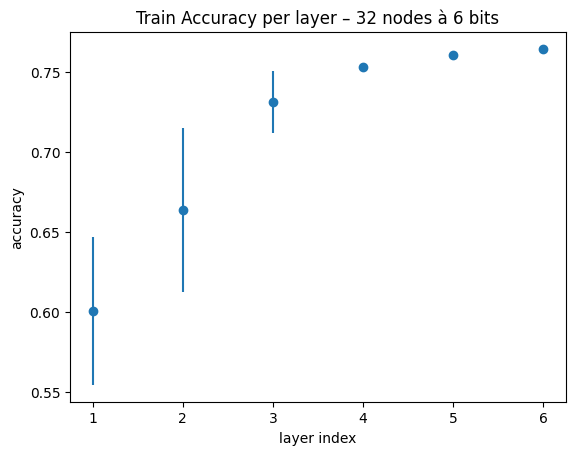

In [4]:
# Accuracy distribution across the 5 hidden layers

layer_count   = 5
node_count    = 32
bit_count     = 6

lut_net = DeepBinaryClassifier(
    nodes_per_layer   =[node_count] * layer_count,
    bits_per_node     =[bit_count]*(layer_count+1),
    node_factory      =make_lut_node,
    rng               =42,
    n_jobs            =1,
)
lut_net.fit(X_train, y_train)

accs_layers = accuracies_per_layer(lut_net, X_train, y_train)
mean_accs   = [np.mean(a) for a in accs_layers]
std_accs    = [np.std (a) for a in accs_layers]

plt.errorbar(range(1, layer_count+2), mean_accs, yerr=std_accs, fmt="o")
plt.xticks(range(1, layer_count+2))
plt.title(f"Train Accuracy per layer – {node_count} nodes à {bit_count} bits")
plt.xlabel("layer index")
plt.ylabel("accuracy")
plt.show()

  2 nodes per layer: train 0.58  |  test 0.57
  4 nodes per layer: train 0.59  |  test 0.58
  8 nodes per layer: train 0.70  |  test 0.72
 16 nodes per layer: train 0.70  |  test 0.72
 32 nodes per layer: train 0.76  |  test 0.75
 64 nodes per layer: train 0.85  |  test 0.83


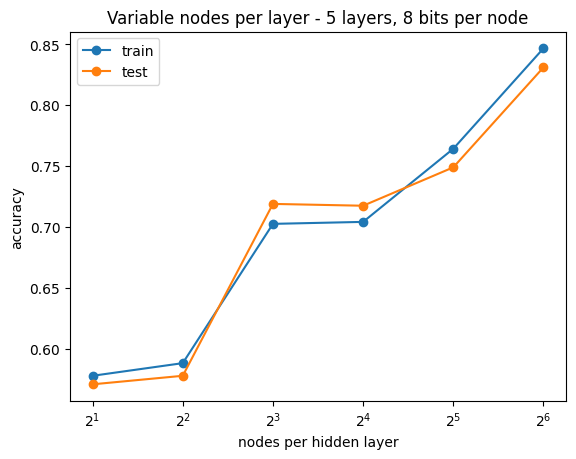

In [5]:
# Variable number of nodes per layer (fixed 8-bit iputs)

layer_count      = 5
node_counts      = [2, 4, 8, 16, 32, 64]
bit_count        = 6

train_acc, test_acc = [], []
for node_count in node_counts:
    lut_net = DeepBinaryClassifier(
        nodes_per_layer   =[node_count]*layer_count,
        bits_per_node     =[bit_count]*(layer_count+1),
        node_factory      =make_lut_node,
        rng               =42,
        n_jobs            =1,
    )
    lut_net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, lut_net.predict(X_train)))
    test_acc .append(accuracy_score(y_test , lut_net.predict(X_test)))

    print(f"{node_count:>3} nodes per layer: train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")

plt.plot(node_counts, train_acc, marker="o", label="train")
plt.plot(node_counts, test_acc , marker="o", label="test")
plt.title("Variable nodes per layer - 5 layers, 8 bits per node")
plt.xlabel("nodes per hidden layer")
plt.ylabel("accuracy")
plt.legend()
plt.xscale("log", base=2)
plt.show()

 2-bit nodes: train 0.58  |  test 0.58
 4-bit nodes: train 0.70  |  test 0.72
 8-bit nodes: train 0.80  |  test 0.71
16-bit nodes: train 1.00  |  test 0.49
20-bit nodes: train 1.00  |  test 0.50


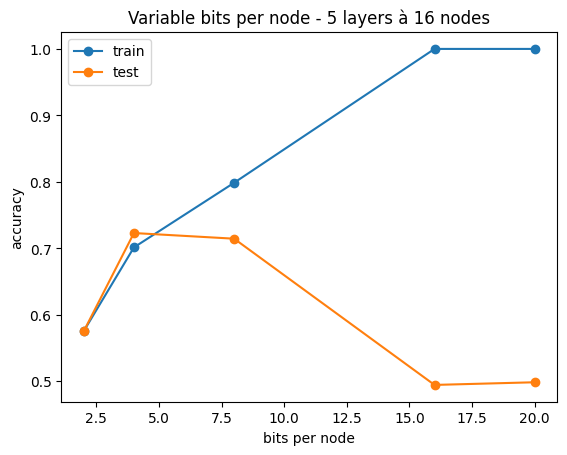

In [6]:
# Variable number of bits per node (fixed 16 nodes per layer)

layer_count     = 5
node_count      = 16
bit_counts      = [2, 4, 8, 16, 20]

train_acc, test_acc = [], []
for bit_count in bit_counts:
    lut_net = DeepBinaryClassifier(
        nodes_per_layer   =[node_count]*layer_count,
        bits_per_node     =[bit_count]*(layer_count+1),
        node_factory      =make_lut_node,
        rng               =42,
        n_jobs            =1,
    )
    lut_net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, lut_net.predict(X_train)))
    test_acc .append(accuracy_score(y_test , lut_net.predict(X_test )))

    print(f"{bit_count:>2}-bit nodes: train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")

plt.plot(bit_counts, train_acc, marker="o", label="train")
plt.plot(bit_counts, test_acc , marker="o", label="test")
plt.title("Variable bits per node - 5 layers à 16 nodes")
plt.xlabel("bits per node")
plt.ylabel("accuracy")
plt.legend()
plt.show()